# Tutorial 7: Beyond Pandas - Third-Party Library Integration

To support end-to-end data science workflows, Ponder supports integrations with other commonly used data science libraries in Python. In this tutorial, we will show examples of how you can work with other visualization and machine learning libraries in Python.

In [1]:
! pip install matplotlib scikit-learn xgboost --quiet

<div class="alert alert-block alert-info"> <b>Note: </b> While Ponder supports pandas operations running on the data warehouse, we do not currently yet support other libraries to run the computation on the warehouse directly. Instead, Ponder pulls the data out of the warehouse and operates it in memory. If the table is exceeds 10k rows, we extract a sample of 10k rows to pull into memory. The focus of this tutorial is to demonstrate how Ponder works well and interoperates with these library. <span>  </span></div>

 ## Visualization

Visualization is a critical part of any exploratory data analysis workflow for identifying patterns and trends in your data. Ponder works out of the box with popular plotting libraries in the PyData ecosystem, including sklearn and matplotlib. 

In [2]:
import ponder.bigquery
import modin.pandas as pd
import json; import os; os.chdir("..")
creds = json.load(open(os.path.expanduser("credential.json")))
bigquery_con = ponder.bigquery.connect(creds, schema = "PONDER")
ponder.bigquery.init(bigquery_con)

Here is an example of how to plot a histogram with Ponder:

In [35]:
df = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/yellow_tripdata_2015-01.csv?raw=True", on_bad_lines='skip')

Creating table in BigQuery...
Finished creating table in BigQuery...
Finished loading data into BigQuery.
Dataframe loading complete.


In [36]:
df.shape

(210035, 17)

<AxesSubplot:ylabel='Frequency'>

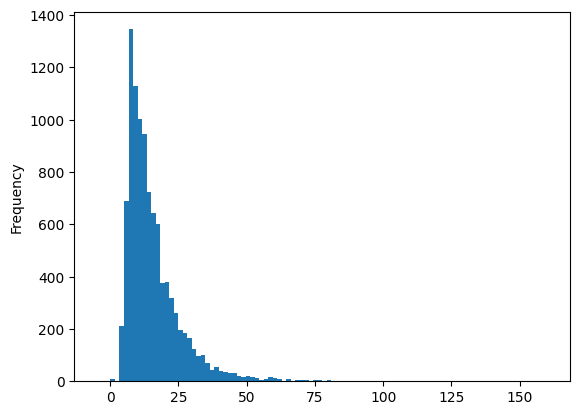

In [37]:
df["TOTAL_AMOUNT"].plot.hist(bins=100)

In [40]:
df.to_sql("PONDER_TAXI",bigquery_con,index=False)

404 Not found: Table innate-empire-381416:PONDER.PONDER_TAXI was not found in location US

Location: US
Job ID: bfc67c70-9ae8-4e84-8978-64289c11368b



In [41]:
df1 = pd.read_sql("PONDER_TAXI",con=bigquery_con)

In [42]:
df1.shape

(210035, 17)

<AxesSubplot:ylabel='Frequency'>

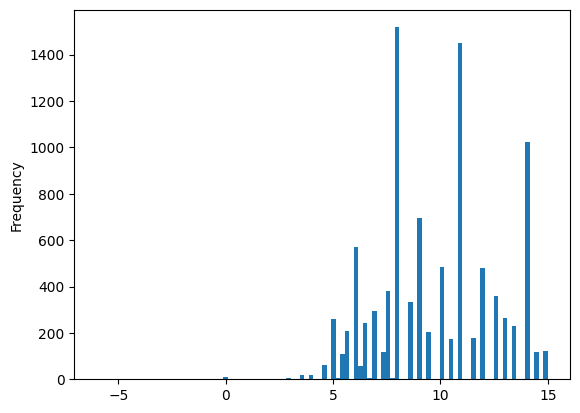

In [47]:
df1["TOTAL_AMOUNT"].plot.hist(bins=100)#,range=[-5,175])

Here is an example of how to plot a scatterplot with Ponder:

Creating table in BigQuery...
Finished creating table in BigQuery...
Finished loading data into BigQuery.
Dataframe loading complete.


<AxesSubplot:xlabel='MilesPerGal', ylabel='Horsepower'>

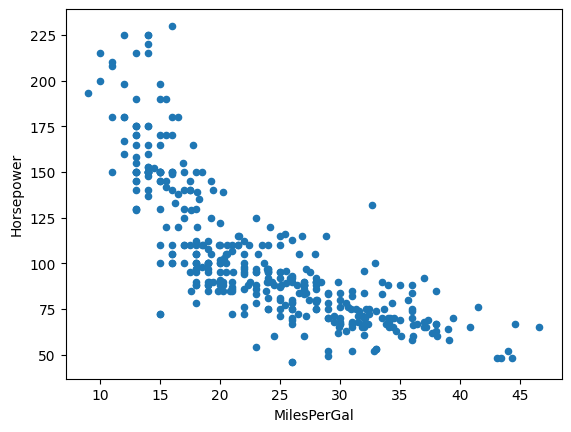

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/lux-org/lux-datasets/master/data/car.csv")
df.plot(x="MilesPerGal",y="Horsepower",kind="scatter")

You can also make more elaborate plots by making using of matplotlib's `plt.plot` functionality directly.

In [6]:
import matplotlib.pyplot as plt

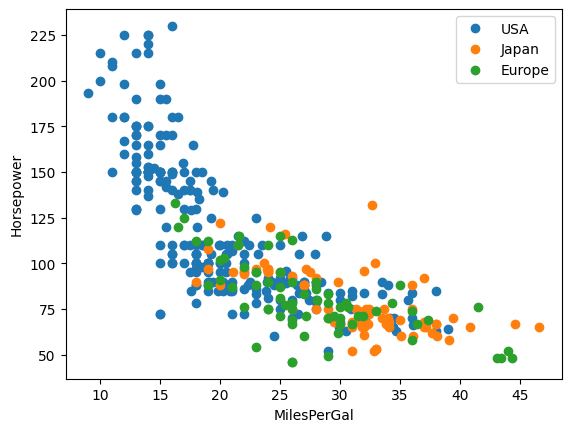

In [7]:
plt.xlabel("MilesPerGal")
plt.ylabel("Horsepower")
for country in df.Origin.unique(): 
    cdf = df[df["Origin"]==country]
    plt.plot(cdf["MilesPerGal"],cdf["Horsepower"],'o',label=country)
plt.legend()

### Machine Learning

Ponder integrates with popular libraries used for machine learning including sci-kit learn, XGBoost, HuggingFace, Tensorflow, and more. Ponder also provides the ability to run NumPy on your data warehouse directly, which is the foundation of machine learning training in Python.


In [8]:
df = pd.read_csv("https://github.com/ponder-org/ponder-datasets/blob/main/USA_Housing.csv?raw=True")

Creating table in BigQuery...
Finished creating table in BigQuery...
Finished loading data into BigQuery.
Dataframe loading complete.


In [9]:
X = df.drop(columns=['PRICE', 'ADDRESS'])
y = df[['PRICE']]

#### Sci-kit Learn

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)

my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [12]:
lr = LinearRegression()
lr.fit(train_X, train_y)
pred_y = lr.predict(test_X)

In [13]:
print(r2_score(pred_y,test_y)*100)

90.59257899764413


### XGBoost

In [14]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [15]:
predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))
print(r2_score(predictions,test_y)*100)

Mean Absolute Error : 88876.82000175689
87.75095359758704
